In [204]:
NOTEBOOK_NAME = "e001_baseline"

In [205]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [206]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [207]:
# train_log = pd.read_csv("../data/train_log.csv")
# train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [208]:
train = pd.read_pickle(
    f"../saved_data/e001_make_train/e001_make_train_merged_train.pkl"
)

test = pd.read_pickle(
    f"../saved_data/e001_make_test/e001_make_test_test_same_lrg_cd_wo_last_yad_no.pkl"
)

In [209]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [210]:
train.shape

(2042541, 4)

In [211]:
test.shape

(14670526, 4)

In [212]:
train.head()

,session_id,yad_no,reserve,logged_yad_no_list
0,000007603d533d30453cc45d0f3d119f,4101,1.0,[2395]
1,0000ca043ed437a1472c9d1d154eb49b,8253,1.0,[13535]
2,0000d4835cf113316fe447e2f80ba1c8,4863,1.0,[123]
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1.0,[8475]
4,000104bdffaaad1a1e0a9ebacf585f33,96,1.0,"[96, 898]"


In [272]:
train[train["session_id"] == "000007603d533d30453cc45d0f3d119f"]

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,fold
0,000007603d533d30453cc45d0f3d119f,4101,1.0,[2395],2395,4101,0,39.0,NaN,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,3
288698,000007603d533d30453cc45d0f3d119f,2395,0.5,[2395],2395,2395,0,113.0,1.0,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,2
599156,000007603d533d30453cc45d0f3d119f,13268,0.0,[2395],2395,13268,0,13.0,NaN,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,1
599157,000007603d533d30453cc45d0f3d119f,7281,0.0,[2395],2395,7281,0,126.0,NaN,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,3
599158,000007603d533d30453cc45d0f3d119f,7448,0.0,[2395],2395,7448,0,24.0,NaN,1,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,3
599159,000007603d533d30453cc45d0f3d119f,1648,0.0,[2395],2395,1648,0,180.0,1.0,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,1
599160,000007603d533d30453cc45d0f3d119f,1987,0.0,[2395],2395,1987,0,5.0,1.0,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,4


In [273]:
test.head(20)

,session_id,yad_no,logged_yad_no_list,last_yad_no,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,pred
0,00001149e9c73985425197104712478c,337,"[3560, 1959]",1959,1959,337,0,6.0,NaN,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.740087
1,00001149e9c73985425197104712478c,360,"[3560, 1959]",1959,1959,360,0,134.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.945678
2,00001149e9c73985425197104712478c,930,"[3560, 1959]",1959,1959,930,0,408.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.921586
3,00001149e9c73985425197104712478c,1063,"[3560, 1959]",1959,1959,1063,0,60.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.295349
4,00001149e9c73985425197104712478c,1286,"[3560, 1959]",1959,1959,1286,0,NaN,NaN,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.934235
5,00001149e9c73985425197104712478c,2680,"[3560, 1959]",1959,1959,2680,0,150.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.073632
6,00001149e9c73985425197104712478c,2811,"[3560, 1959]",1959,1959,2811,0,49.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.041217
7,00001149e9c73985425197104712478c,2911,"[3560, 1959]",1959,1959,2911,0,105.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.463880
8,00001149e9c73985425197104712478c,2986,"[3560, 1959]",1959,1959,2986,0,104.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.912013
9,00001149e9c73985425197104712478c,3039,"[3560, 1959]",1959,1959,3039,0,10.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.061922


In [214]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [215]:
# ひとつ前のlogのyad_idの値を取得
train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

In [216]:
train.head()

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no
0,000007603d533d30453cc45d0f3d119f,4101,1.0,[2395],2395
1,0000ca043ed437a1472c9d1d154eb49b,8253,1.0,[13535],13535
2,0000d4835cf113316fe447e2f80ba1c8,4863,1.0,[123],123
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1.0,[8475],8475
4,000104bdffaaad1a1e0a9ebacf585f33,96,1.0,"[96, 898]",898


In [217]:
test.head()

,session_id,yad_no,logged_yad_no_list,last_yad_no,previous_1_yad_no
0,00001149e9c73985425197104712478c,337,"[3560, 1959]",1959,1959
0,00001149e9c73985425197104712478c,360,"[3560, 1959]",1959,1959
0,00001149e9c73985425197104712478c,930,"[3560, 1959]",1959,1959
0,00001149e9c73985425197104712478c,1063,"[3560, 1959]",1959,1959
0,00001149e9c73985425197104712478c,1286,"[3560, 1959]",1959,1959


# 正解のyadoと1つ前のyadoの情報の追加

In [218]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [219]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [220]:
train.head()

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,000007603d533d30453cc45d0f3d119f,4101,1.0,[2395],2395,4101,0,39.0,NaN,0,...,1.0,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
1,0000ca043ed437a1472c9d1d154eb49b,8253,1.0,[13535],13535,8253,0,26.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,b07b75d367ebece55a23ceecc939fff4,0a66f6ab9c0507059da6f22a0e1f1690,9ab5718fd88c6e5f9fec37a51827d428,7aff71bb47acb796d425c5ed5e6dfb3f
2,0000d4835cf113316fe447e2f80ba1c8,4863,1.0,[123],123,4863,0,30.0,1.0,0,...,1.0,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,dac434451fe9bd50068191f41fe792e3,b7c56c5d2855b39366b4ebe9a4eded93
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1.0,[8475],8475,1652,0,127.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2
4,000104bdffaaad1a1e0a9ebacf585f33,96,1.0,"[96, 898]",898,96,0,228.0,1.0,0,...,1.0,0,NaN,NaN,NaN,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650


In [221]:
test.head()

,session_id,yad_no,logged_yad_no_list,last_yad_no,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,00001149e9c73985425197104712478c,337,"[3560, 1959]",1959,1959,337,0,6.0,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
1,00001149e9c73985425197104712478c,360,"[3560, 1959]",1959,1959,360,0,134.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
2,00001149e9c73985425197104712478c,930,"[3560, 1959]",1959,1959,930,0,408.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
3,00001149e9c73985425197104712478c,1063,"[3560, 1959]",1959,1959,1063,0,60.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
4,00001149e9c73985425197104712478c,1286,"[3560, 1959]",1959,1959,1286,0,NaN,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0


# データ型の変更

In [222]:
# categorical_colの定義
base_categorical_cols = [
    "yad_no",
    "yad_type",
    # "wid_cd", # retrieveの条件が同じken_cdのデータの予定のため、今は学習に使わない
    # "ken_cd", # retrieveの条件が同じken_cdのデータの予定のため、今は学習に使わない
    "lrg_cd",
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
previous_1_yado_categorical_cols = [
    f"previous_1_{col}" for col in base_categorical_cols
]

categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols

In [223]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [224]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
for fold, (_, v_idx) in enumerate(
    skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

In [225]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0.0        0.706660
      0.5        0.151997
      1.0        0.141343
1     0.0        0.706662
      0.5        0.151995
      1.0        0.141344
2     0.0        0.706662
      0.5        0.151995
      1.0        0.141344
3     0.0        0.706662
      0.5        0.151997
      1.0        0.141341
4     0.0        0.706662
      0.5        0.151997
      1.0        0.141341
Name: proportion, dtype: float64

# LightGBM

In [226]:
train.head()

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,fold
0,000007603d533d30453cc45d0f3d119f,4101,1.0,[2395],2395,4101,0,39.0,NaN,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,3
1,0000ca043ed437a1472c9d1d154eb49b,8253,1.0,[13535],13535,8253,0,26.0,1.0,0,...,0,1.0,NaN,NaN,1.0,b07b75d367ebece55a23ceecc939fff4,0a66f6ab9c0507059da6f22a0e1f1690,9ab5718fd88c6e5f9fec37a51827d428,7aff71bb47acb796d425c5ed5e6dfb3f,4
2,0000d4835cf113316fe447e2f80ba1c8,4863,1.0,[123],123,4863,0,30.0,1.0,0,...,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,dac434451fe9bd50068191f41fe792e3,b7c56c5d2855b39366b4ebe9a4eded93,2
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1.0,[8475],8475,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,3
4,000104bdffaaad1a1e0a9ebacf585f33,96,1.0,"[96, 898]",898,96,0,228.0,1.0,0,...,0,NaN,NaN,NaN,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,3


In [227]:
test.head()

,session_id,yad_no,logged_yad_no_list,last_yad_no,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,00001149e9c73985425197104712478c,337,"[3560, 1959]",1959,1959,337,0,6.0,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
1,00001149e9c73985425197104712478c,360,"[3560, 1959]",1959,1959,360,0,134.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
2,00001149e9c73985425197104712478c,930,"[3560, 1959]",1959,1959,930,0,408.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
3,00001149e9c73985425197104712478c,1063,"[3560, 1959]",1959,1959,1063,0,60.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
4,00001149e9c73985425197104712478c,1286,"[3560, 1959]",1959,1959,1286,0,NaN,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0


In [228]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col

In [229]:
use_col = numeric_cols + categorical_cols
len(use_col)

22

In [233]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 3,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.5,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
}

In [231]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [234]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    score = rmse(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred
    # TODO: 最終的には全foldを回す
    break

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.234012	valid_1's rmse: 0.236594
[200]	training's rmse: 0.212213	valid_1's rmse: 0.21597
[300]	training's rmse: 0.203651	valid_1's rmse: 0.208334
[400]	training's rmse: 0.19866	valid_1's rmse: 0.203987
[500]	training's rmse: 0.195553	valid_1's rmse: 0.201249
[600]	training's rmse: 0.193599	valid_1's rmse: 0.199539
[700]	training's rmse: 0.191736	valid_1's rmse: 0.197881
[800]	training's rmse: 0.190462	valid_1's rmse: 0.196782
[900]	training's rmse: 0.1894	valid_1's rmse: 0.195935
[1000]	training's rmse: 0.188333	valid_1's rmse: 0.195045
[1100]	training's rmse: 0.187432	valid_1's rmse: 0.19429
[1200]	training's rmse: 0.186541	valid_1's rmse: 0.193567
[1300]	training's rmse: 0.185801	valid_1's rmse: 0.192992
[1400]	training's rmse: 0.185168	valid_1's rmse: 0.192488
[1500]	training's rmse: 0.184411	valid_1's rmse: 0.191849
[1600]	training's rmse: 0.183802	valid_1's rmse: 0.191359
[1700]	trai

KeyboardInterrupt: 

In [235]:
train[Config.TARGET_COL]

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
2042536    0.0
2042537    0.0
2042538    0.0
2042539    0.0
2042540    0.0
Name: reserve, Length: 2042541, dtype: float64

In [238]:
# oofの0の値のindexを取得
zero_indices = oof[oof == 0]

In [240]:
oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.18234747852396077

<Axes: >

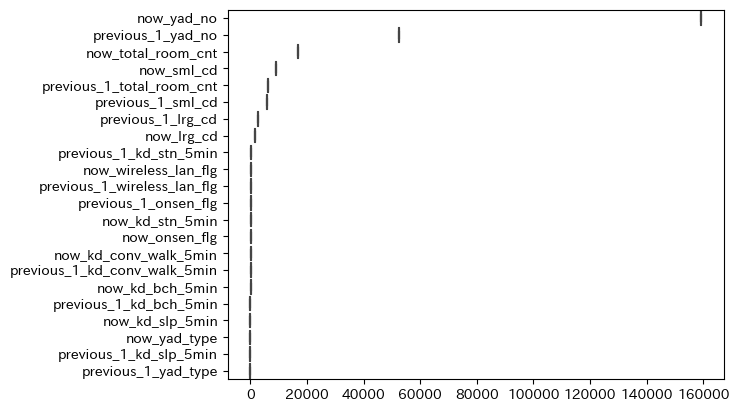

In [241]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [242]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

# Testに対する推論

In [243]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

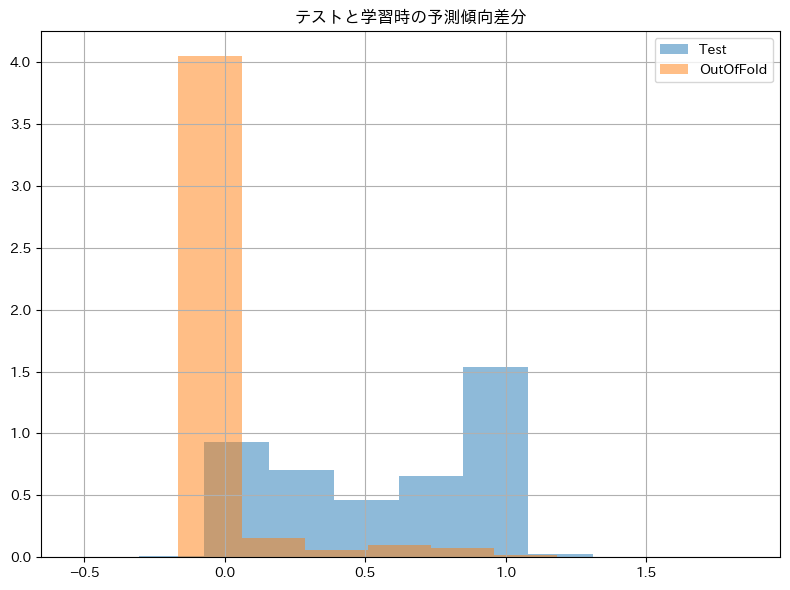

In [244]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [245]:
test["pred"] = pred

In [246]:
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

In [247]:
test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

In [265]:
test_session

,session_id,pred_yad_no_list,pred_yad_no_list_top10
0,00001149e9c73985425197104712478c,"[10965, 4128, 3560, 10233, 12834, 13192, 5466,...","[10965, 4128, 3560, 10233, 12834, 13192, 5466,..."
1,0000e02747d749a52b7736dfa751e258,"[13249, 7913, 158, 1266, 11923, 8821, 10023, 6...","[13249, 7913, 158, 1266, 11923, 8821, 10023, 6..."
2,0000f17ae2628237d78d3a38b009d3be,"[10485, 1774, 410, 7710, 757, 9910, 6721, 1010...","[10485, 1774, 410, 7710, 757, 9910, 6721, 1010..."
3,000174a6f7a569b84c5575760d2e9664,"[3750, 3359, 10527, 4180, 10535, 13022, 1844, ...","[3750, 3359, 10527, 4180, 10535, 13022, 1844, ..."
4,00017e2a527901c9c41b1acef525d016,"[8086, 737, 1346, 2319, 6116, 11494, 1524, 951...","[8086, 737, 1346, 2319, 6116, 11494, 1524, 951..."
...,...,...,...
174695,fffee3199ef94b92283239cd5e3534fa,"[11008, 11848, 10042, 11503, 10997, 6813, 2278...","[11008, 11848, 10042, 11503, 10997, 6813, 2278..."
174696,ffff62c6bb49bc9c0fbcf08494a4869c,"[2232, 13702, 9723, 2491, 3802, 11243, 4181, 4...","[2232, 13702, 9723, 2491, 3802, 11243, 4181, 4..."
174697,ffff9a7dcc892875c7a8b821fa436228,"[2449, 12089, 4040, 4398, 11850, 8975, 3929, 2...","[2449, 12089, 4040, 4398, 11850, 8975, 3929, 2..."
174698,ffffb1d30300fe17f661941fd085b04b,"[4692, 12612, 8501, 4049, 1530, 1354, 2614, 12...","[4692, 12612, 8501, 4049, 1530, 1354, 2614, 12..."


In [271]:
yado[
    yado["yad_no"].isin(
        [
            11984,
            13249,
            7913,
            158,
        ]
    )
]

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
157,158,0,227.0,NaN,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab
7912,7913,0,148.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab
11983,11984,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab
13248,13249,0,33.0,1.0,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab


In [266]:
test_log

,session_id,seq_no,yad_no
0,00001149e9c73985425197104712478c,0,3560
1,00001149e9c73985425197104712478c,1,1959
2,0000e02747d749a52b7736dfa751e258,0,11984
3,0000f17ae2628237d78d3a38b009d3be,0,757
4,0000f17ae2628237d78d3a38b009d3be,1,8922
...,...,...,...
250300,fffee3199ef94b92283239cd5e3534fa,1,8336
250301,ffff62c6bb49bc9c0fbcf08494a4869c,0,12062
250302,ffff9a7dcc892875c7a8b821fa436228,0,8989
250303,ffffb1d30300fe17f661941fd085b04b,0,6030


In [255]:
# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

In [256]:
# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

In [257]:
pred_yad_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,10965.0,4128.0,3560.0,10233.0,12834.0,13192.0,5466.0,4545.0,6563.0,8633.0
1,13249.0,7913.0,158.0,1266.0,11923.0,8821.0,10023.0,6555.0,5267.0,12862.0
2,10485.0,1774.0,410.0,7710.0,757.0,9910.0,6721.0,10104.0,2267.0,4999.0
3,3750.0,3359.0,10527.0,4180.0,10535.0,13022.0,1844.0,6991.0,7049.0,2363.0
4,8086.0,737.0,1346.0,2319.0,6116.0,11494.0,1524.0,9516.0,2822.0,462.0


In [258]:
pred_yad_df.isnull().sum()

predict_0      0
predict_1      0
predict_2      0
predict_3      0
predict_4     47
predict_5    159
predict_6    476
predict_7    619
predict_8    735
predict_9    953
dtype: int64

In [259]:
# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
pred_yad_df = pred_yad_df.fillna(0).astype(int)

In [260]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [261]:
pred_yad_df.to_csv(f"../sub/{NOTEBOOK_NAME}_{oof_score:.4f}.csv", index=False)

In [262]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,10965,4128,3560,10233,12834,13192,5466,4545,6563,8633
1,13249,7913,158,1266,11923,8821,10023,6555,5267,12862
2,10485,1774,410,7710,757,9910,6721,10104,2267,4999
3,3750,3359,10527,4180,10535,13022,1844,6991,7049,2363
4,8086,737,1346,2319,6116,11494,1524,9516,2822,462
...,...,...,...,...,...,...,...,...,...,...
174695,11008,11848,10042,11503,10997,6813,2278,6771,9743,9543
174696,2232,13702,9723,2491,3802,11243,4181,4014,2164,13302
174697,2449,12089,4040,4398,11850,8975,3929,2425,13782,6630
174698,4692,12612,8501,4049,1530,1354,2614,12693,13107,12043


In [263]:
sample_submission

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,12217,5055,4744,3410,11442,3711,8190,9998,13023,9297
1,12340,13720,1378,681,2020,11125,10129,4159,8184,7966
2,196,8757,6241,7376,13608,1693,13745,8065,13022,303
3,6448,3482,5687,2335,911,9008,8209,595,8171,10040
4,6327,1606,12898,3785,8212,910,10430,4260,9767,383
...,...,...,...,...,...,...,...,...,...,...
174695,10343,11384,5571,2011,3762,12692,6599,8738,8343,6440
174696,13609,2644,11510,5711,13054,9903,13750,8638,1892,5086
174697,11560,1862,11248,63,12446,9975,13567,7793,5306,9678
174698,7001,4154,11586,3307,13219,12310,5815,5103,510,1351
